# Mise en situation

Vous êtes employé chez Enercoop, société coopérative qui s'est développée grâce à la libéralisation du marché de l’électricité en France. Elle est spécialisée dans les énergies renouvelables.

La plupart de ces énergies renouvelables est cependant intermittente, il est donc difficile de prévoir les capacités de production d'électricité. De plus, la demande en électricité des utilisateurs varie au cours du temps, et dépend de paramètres comme la météo (température, luminosité, etc.) Tout le challenge est de mettre en adéquation l'offre et la demande !

# Mission
Vous vous concentrerez uniquement sur la prédiction de la demande en électricité.

* Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.


* Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.


* Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de ***Holt Winters (lissage exponentiel)*** puis la méthode ***SARIMA*** sur la série temporelle.

In [1]:
#Import des principales librairies Python
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
import itertools
import warnings 

from multiprocessing import cpu_count
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import ExponentialSmoothing
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import ProbPlot
from scipy.stats import shapiro
from IPython.display import clear_output
from time import time
from sklearn import linear_model
from joblib import Parallel
from joblib import delayed
from functions import *
from datetime import datetime


warnings.filterwarnings('ignore')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
#Paramètres de style
pylab.style.use('seaborn-deep') 
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (20, 10),
          'lines.linewidth': 1.5,
          'axes.labelsize': 'x-large',
          'axes.titlesize':25,
          'axes.titleweight':'bold',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

In [3]:
#Chargement du dataset 'consommation.csv'
data_conso = pd.read_csv('data/consommation_mensuelle.csv', sep=';', parse_dates=[0])
data_conso.head(5)

,Mois,Qualité,Territoire,Production totale,Production nucléaire,Production thermique totale,Production thermique charbon,Production thermique fioul,Production thermique gaz,Production hydraulique,...,Production bioénergies,Consommation totale,Solde exportateur,Echanges export,Echanges import,Echanges avec le Royaume-Uni,Echanges avec l'Espagne,Echanges avec l'Italie,Echanges avec la Suisse,Echanges avec l'Allemagne et la Belgique
0,2012-01-01,Données définitives,France,57177,42811.0,5399,741.0,691,3967,6741,...,514,51086,5371.0,7043.0,1672.0,929.0,724.0,1581.0,2195.0,-59.0
1,2012-02-01,Données définitives,France,54419,38661.0,8721,2511.0,1309,4901,5244,...,454,54476,-715.0,4504.0,5220.0,-798.0,-309.0,1244.0,1579.0,-2430.0
2,2012-03-01,Données définitives,France,48583,37549.0,5276,1435.0,666,3175,3894,...,531,43156,4888.0,7042.0,2153.0,583.0,330.0,1742.0,2235.0,-1.0
3,2012-04-01,Données définitives,France,44192,33100.0,3484,1655.0,486,1343,5302,...,405,40176,3447.0,5762.0,2314.0,547.0,-9.0,1271.0,1670.0,-31.0
4,2012-05-01,Données définitives,France,40433,29058.0,1772,854.0,368,549,7706,...,469,35257,4425.0,6391.0,1965.0,693.0,251.0,1341.0,1060.0,1079.0


## Traitement et correction des données


In [4]:
#Création d'un jeu de données mensuelles de consommation totale d'électricité en énergie 
#Restriction sur la modalité 'France' et projection sur les Series pertinentes
conso = data_conso.copy()
conso = conso[['Mois', 'Territoire', 'Consommation totale']]
conso = conso[conso['Territoire'] == 'France']
conso.drop('Territoire', axis=1, inplace=True)
conso.rename(columns={'Mois': 'mois', 'Consommation totale': 'consommation'}, inplace=True)

#Recherche de valeurs aberrantes comme celle de la première ligne 
conso.sort_values(by='mois', ascending=True).head(2)

,mois,consommation
0,2012-01-01,51086
1,2012-02-01,54476


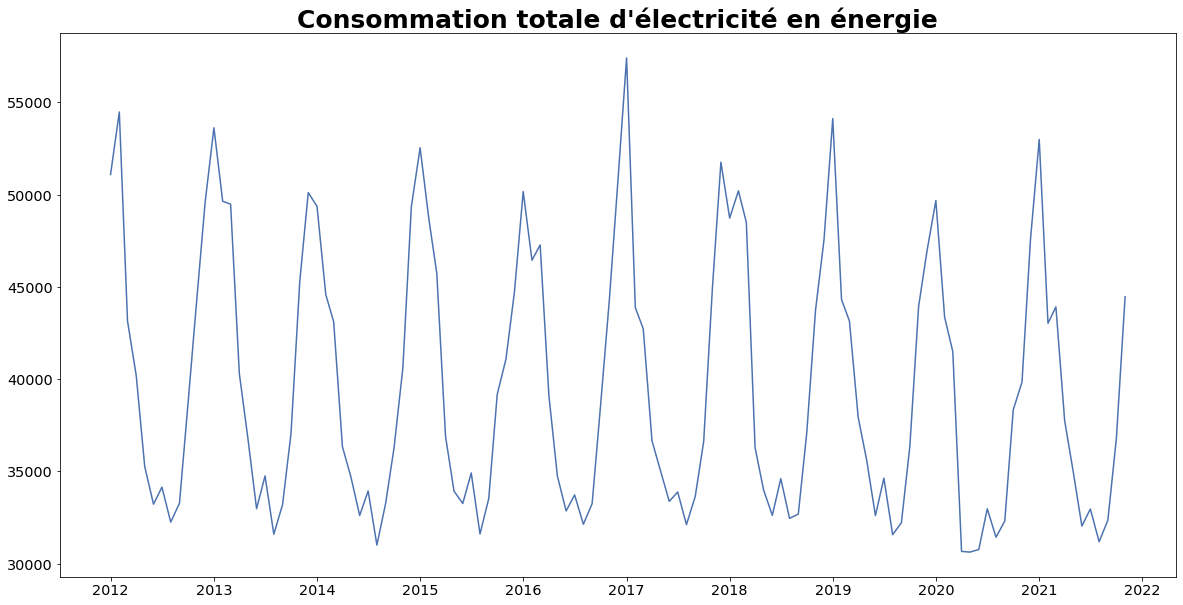

In [5]:
#Changement du type de Series en datetime
#Changement d'index pour que la série temporelle soit reconnue
conso['mois'] = pd.to_datetime(conso['mois'])
conso.set_index('mois', inplace=True)

#Visualisation de la consommation totale d'électricité en énergie 
plt.plot(conso.consommation)
plt.title("Consommation totale d'électricité en énergie")
plt.savefig("p9_graphic/conso_elect.png")
plt.show()

Dans la série temporelle ci-dessus on peut identifier des cycles assez réguliers au cours du temps et de même amplitude. Une correction des données de consommation mensuelles de l'effet température (dues au chauffage électrique) sera faite à l’aide de la régression linéaire.

Il est donc nécessaire d'extraire les données propres au chauffage électrique sur la même période.

In [52]:
#Récapitulatif des consommations annuelles
conso_an = conso.resample('Y').sum()

L'agrégation des consommations mensuelles par année apporte également une vision rapide des dépenses énergétiques entre 2012 et 2021. 2013 étant l'année avec une consomation d'énergie plus élevée.

### **Traitement du jeu de données exporté du site Cegibat, l'expertise efficacité énergétique de GRDF**

degrés jour = DJ ou DJU

In [7]:
#Chargement du dataset 'dju.xlsx'
data_dju = pd.read_excel('data/dju_rossy.xlsx', header=None, skiprows=11)
data_dju.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,NaN,JAN,FÉV,MAR,AVR,MAI,JUN,JUI,AOÛ,SEP,OCT,NOV,DÉC,Total
1,2021.0,421.1,324.5,301.6,274.5,162.7,3.7,0,0,0,0,0,0,1487.8
2,2020.0,367,270.1,297.9,111.7,94.3,27.3,3.9,6.5,39.7,166.2,246.3,353.1,1983.8
3,2019.0,433.4,288.5,259.8,197.6,147.1,31.2,3.2,2.9,37.7,146.5,295.5,347.7,2190.9
4,2018.0,324.9,453.6,333.6,137,80,15.2,0.1,5.2,50.4,138.4,297,346,2181.3


L'année 2021 ne peut pas être prise en compte, on peut constater des valeurs nulles sur des mois d'hiver, donc cela peut compromettre notre analyse.

In [8]:
#Suppression des deux premières lignes et dernière Series
data_dju.drop([0, 1], axis=0, inplace=True)
data_dju.drop([13], axis=1, inplace=True)

#La première Series est considérée comme index
data_dju[0] = data_dju[0].astype(int)
data_dju.set_index([0], inplace=True)

#Affichage des premières lignes du dataframe 
data_dju.head(2)

,1,2,3,4,5,6,7,8,9,10,11,12
0,,,,,,,,,,,,
2020,367,270.1,297.9,111.7,94.3,27.3,3.9,6.5,39.7,166.2,246.3,353.1
2019,433.4,288.5,259.8,197.6,147.1,31.2,3.2,2.9,37.7,146.5,295.5,347.7


In [9]:
#Transformation des données
dju = {'mois':[],'dju_chauffage':[]}

for year in data_dju.index.values:
    for month in data_dju.columns:
        dju['mois'].append(f"{year}-{month}")
        dju['dju_chauffage'].append(data_dju.loc[year,month])
        
dju = pd.DataFrame(dju)
dju['mois'] = pd.to_datetime(dju['mois'])

#Indexation des données selon les mois d'enregistrement
dju.set_index('mois', inplace=True)

#Aperçu des données mensuelles du chauffage électrique (dataframe "dju")
display(dju.head(3))

,dju_chauffage
mois,
2020-01-01,367.0
2020-02-01,270.1
2020-03-01,297.9


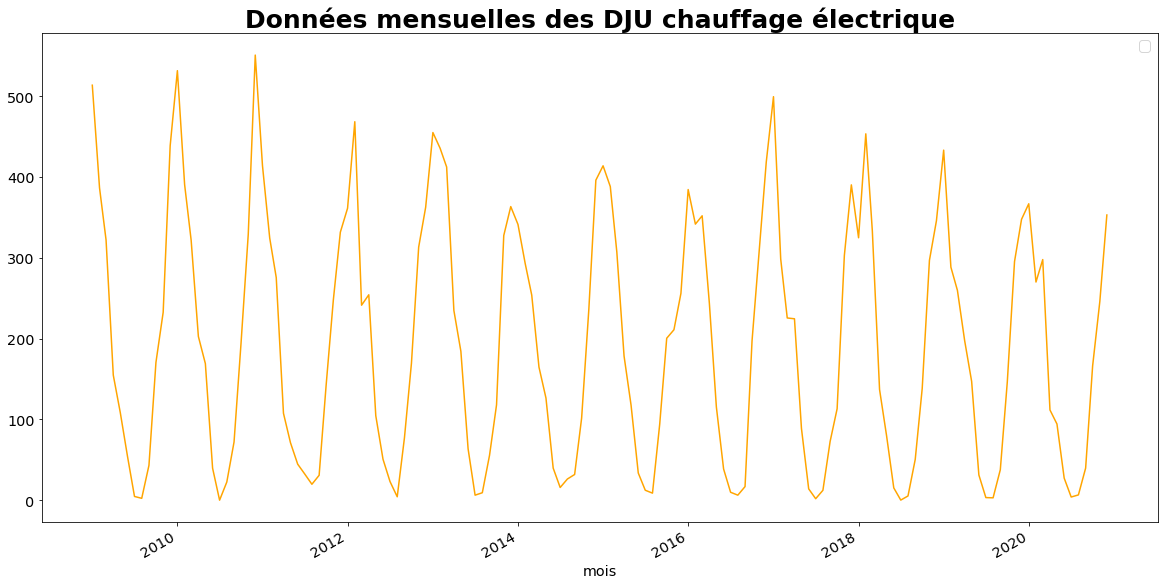

In [10]:
#Visualisation des données mensuelles des Degrés Jour Unifiés (DJU) chauffage électrique
dju.plot(color='orange')
plt.title("Données mensuelles des DJU chauffage électrique")
plt.savefig("p9_graphic/dju_chauffage_elec.png")
plt.legend("")
plt.show()

In [11]:
#Création d'un échantillon de travail par jointure des deux précédents dataframe
df = pd.merge(conso, dju, how='inner', on='mois')

#Vérification rapide des éventuelles valeurs manquantes dans l'échantillon
df.isna().any()

consommation     False
dju_chauffage    False
dtype: bool

In [12]:
#Statistiques descriptives de l'échantillon
df.describe().T

,count,mean,std,min,25%,50%,75%,max
consommation,108.0,39737.250000,7086.595702,30622.0,33347.750,37082.5,45047.50,57406.0
dju_chauffage,108.0,188.733333,146.859754,0.1,39.425,174.0,311.05,499.6


In [13]:
df

,consommation,dju_chauffage
mois,,
2012-01-01,51086,361.5
2012-02-01,54476,468.6
2012-03-01,43156,241.4
2012-04-01,40176,254.3
2012-05-01,35257,104.6
...,...,...
2020-08-01,31428,6.5
2020-09-01,32307,39.7
2020-10-01,38332,166.2


## Mission 1

* Corrigez les données de consommation mensuelles de l'effet température (dues au chauffage électrique) en utilisant une régression linéaire.

In [14]:
#Préparation des données pour établir la Régression linéaire par Scikit-learn
y=df['consommation']
x=df.drop(columns=['consommation'])

#Régression linéaire 
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(x, y)

#Coefficient de régression linéaire
reg.coef_[0]

46.60948640583874

In [15]:
#Le modèle de Régression linéaire peut également être traité par Statsmodel

#Préparation des données pour établir la Régression linéaire
y = df['consommation']
x = sm.add_constant(df['dju_chauffage'])

#Nouvelle Régression linéaire par Statsmodels
#Instanciation du modèle et entrainement
reg = sm.OLS(y, x).fit()
print(reg.summary())

                            OLS Regression Results                            
Dep. Variable:           consommation   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.932
Method:                 Least Squares   F-statistic:                     1476.
Date:                Wed, 16 Feb 2022   Prob (F-statistic):           4.86e-64
Time:                        17:39:29   Log-Likelihood:                -964.31
No. Observations:                 108   AIC:                             1933.
Df Residuals:                     106   BIC:                             1938.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          3.094e+04    289.622    106.831

In [16]:
#Coefficient de régression linéaire
reg.params['dju_chauffage']

46.60948640583874

Le coefficient de régression linéaire est vérifié par les deux méthodes, de plus il est identique à celui estimé par le précédent modèle via Scikit-learn.

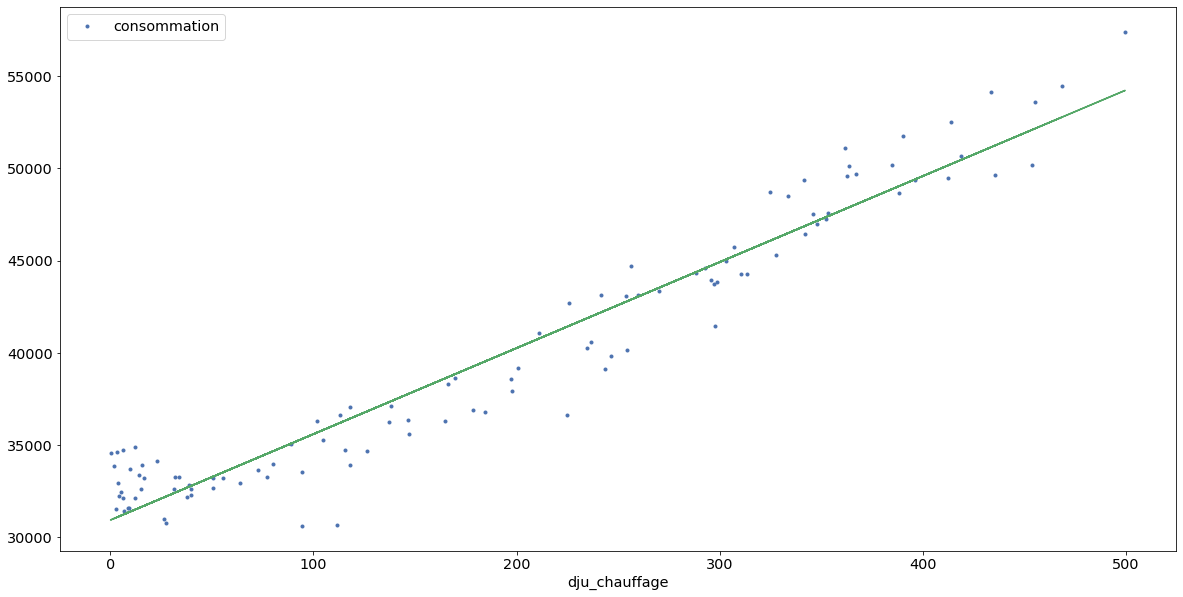

In [17]:
#Représentation de la Régression linéaire obtenue
df.plot(x='dju_chauffage', y='consommation', style='.', figsize =(20, 10))
plt.plot(df['dju_chauffage'], reg.predict(sm.add_constant(df['dju_chauffage'])))

plt.savefig("p9_graphic/regression_lineaire_conso_dju.png")
plt.show()

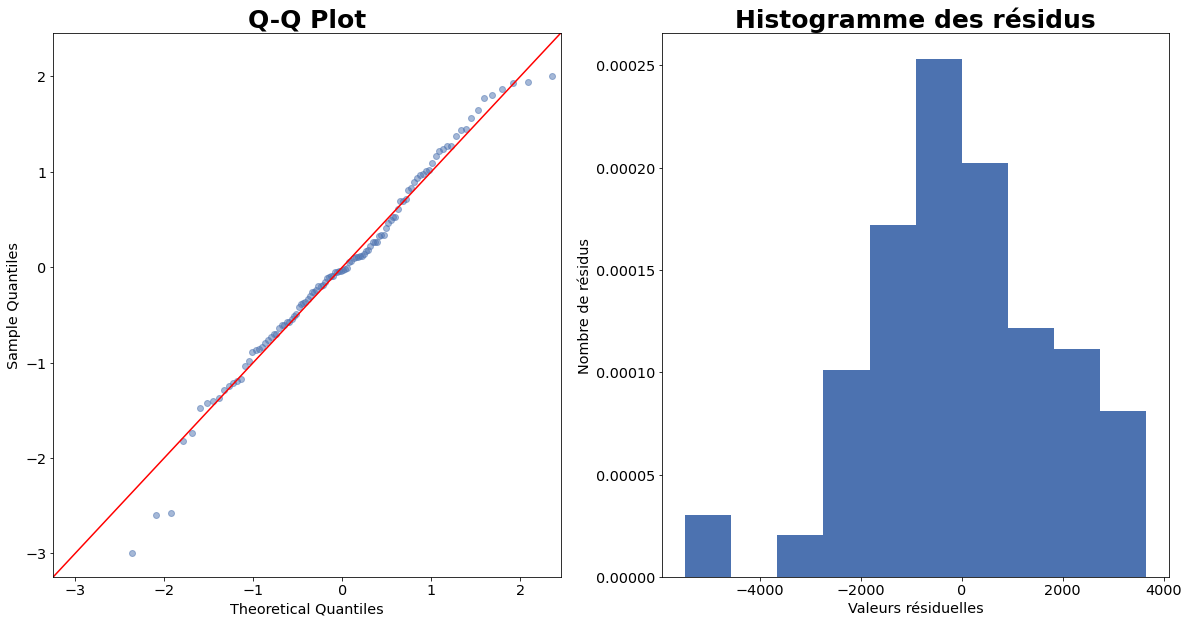

In [18]:
#Test de normalité des résidus
#Distribution des résidus
fig, ax = plt.subplots(1, 2, figsize=(20,10))

plt.hist(reg.resid, density=True)

model_norm_residuals = reg.get_influence().resid_studentized_internal
QQ = ProbPlot(model_norm_residuals)
QQ.qqplot(line='45', alpha=0.5, color='#4C72B0', ax=ax[0])

ax[0].set_title('Q-Q Plot')
ax[1].set_title('Histogramme des résidus')
ax[1].set_xlabel('Valeurs résiduelles')
ax[1].set_ylabel('Nombre de résidus')
                
plt.savefig('p9_graphic/qqplot_histo_residus_reg.jpg')
plt.show()

On peut identifier une distribution des résidus alignée avec la distribution théorique d'une loi normale. 

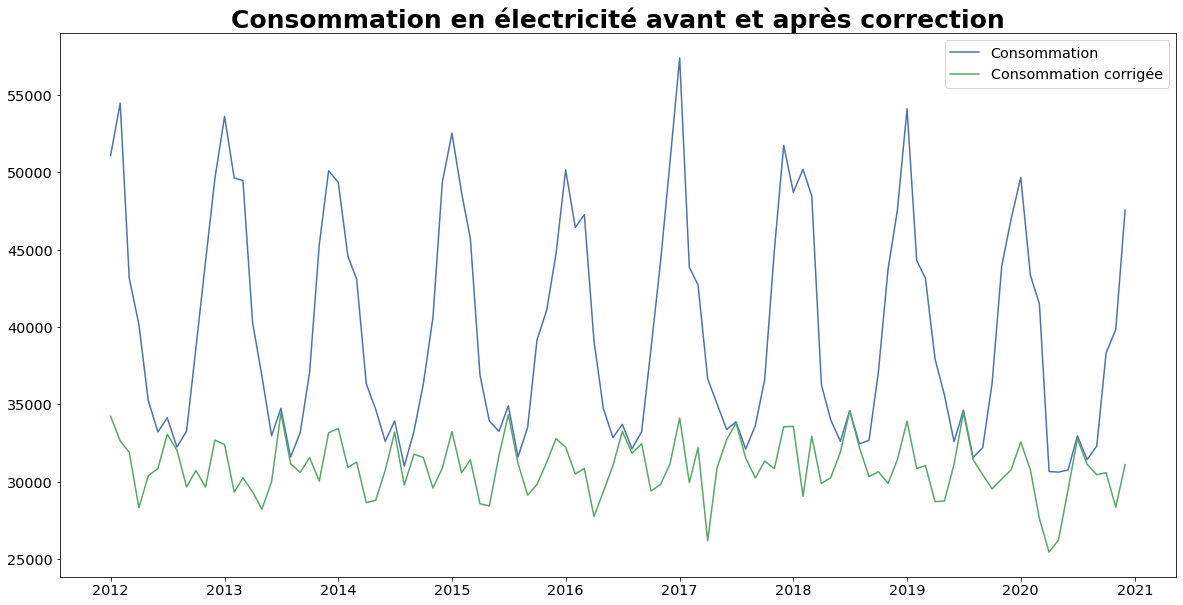

In [19]:
#Calcul de la correction : l'effet DJU est retranché à la consommation totale
df['conso_corr'] = df['consommation'] - df['dju_chauffage']*reg.params['dju_chauffage']

#Visualisation de la consommation en électricité avant et après correction
plt.plot(df['consommation'], label='Consommation')
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.title('Consommation en électricité avant et après correction')

plt.savefig("p9_graphic/conso_corr.png")
plt.legend()
plt.show()

## Mission 2

* Effectuez une désaisonnalisation de la consommation que vous aurez obtenue après correction, grâce aux moyennes mobiles.

La méthode seasonal_decompose de statsmodels permet de visualiser la tendance, la saisonnalité et le résidu du signal.

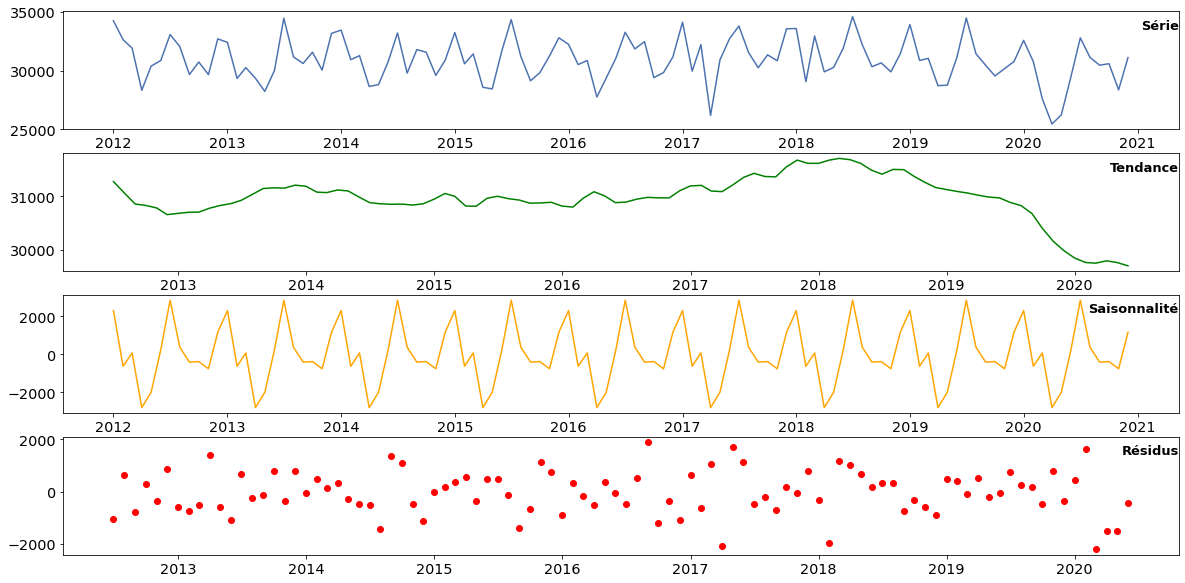

In [20]:
decomposition = seasonal_decompose(df['conso_corr'],  model='additive')
fig, ax = plt.subplots(4,1)
ax[0].plot(decomposition.observed)
ax[0].set_title('Série', fontsize=13, y = 0.8, loc = 'right')
print(" ")
ax[1].plot(decomposition.trend, 'green')
ax[1].set_title('Tendance', fontsize=13, y = 0.8, loc = 'right')
print(" ")
ax[2].plot(decomposition.seasonal, 'orange')
ax[2].set_title('Saisonnalité', fontsize=13, y = 0.8, loc = 'right')
print(" ")
ax[3].plot(decomposition.resid,'bo', color='r')
ax[3].set_title('Résidus', fontsize=13, y = 0.8, loc = 'right')

plt.savefig('p9_graphic/decomposition.jpg')
plt.show()

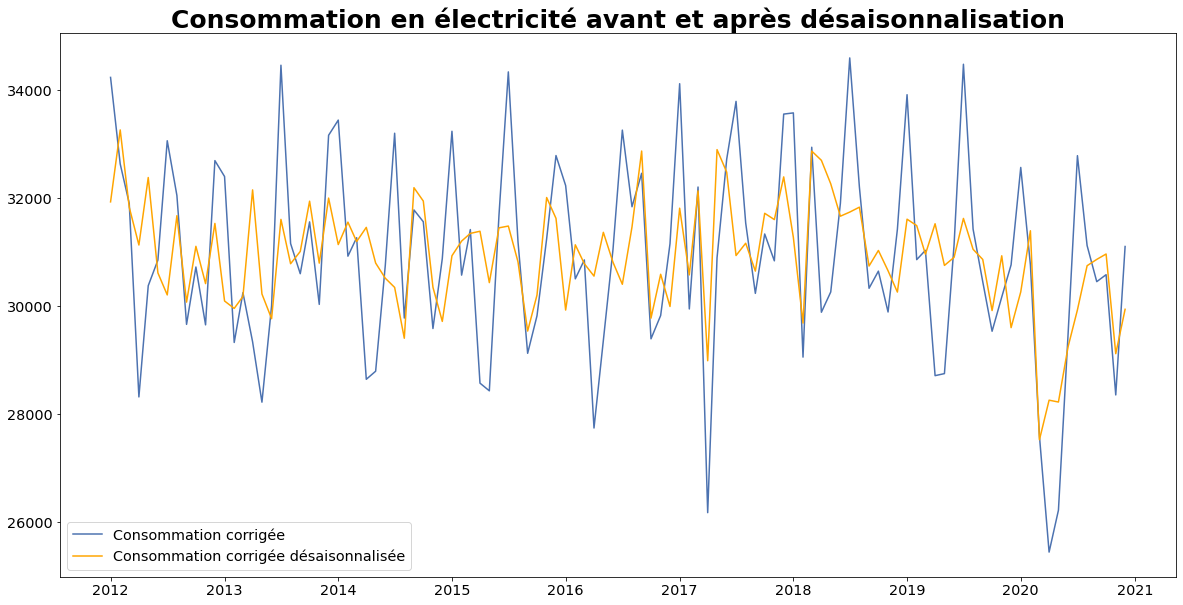

In [21]:
#Différence avec la saisonnalité pour obtenir une série temporelle hors impact saisonnier
df['conso_cvs'] = df['conso_corr'] - decomposition.seasonal

#Visualisation de la consommation en électricité avant et après désaisonnalisation
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_cvs'], label='Consommation corrigée désaisonnalisée', color ='orange')
plt.title('Consommation en électricité avant et après désaisonnalisation')

plt.savefig("p9_graphic/conso_cvs.png")
plt.legend()
plt.show()

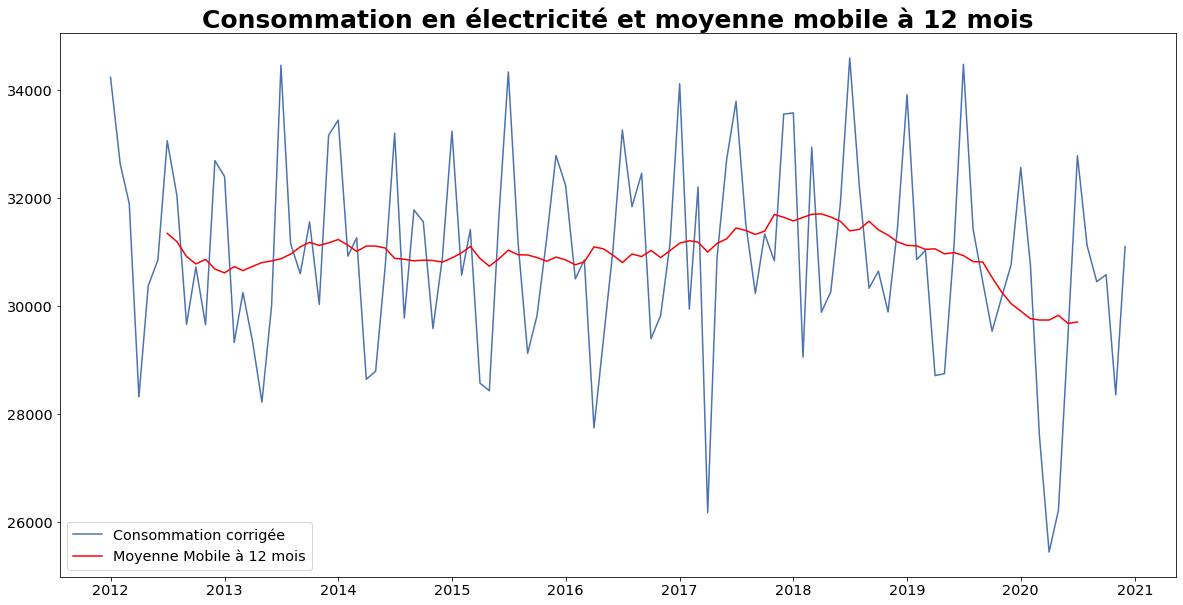

In [22]:
#Visualisation de la consommation en électricité avec moyenne mobile à 12 mois
plt.plot(df['conso_corr'], label='Consommation corrigée')
plt.plot(df['conso_corr'].rolling(12, center=True).mean(), label='Moyenne Mobile à 12 mois', color='r')


plt.title('Consommation en électricité et moyenne mobile à 12 mois')

plt.savefig("p9_graphic/conso_moyenne_mobile.png")
plt.legend()
plt.show()

### Mission 3


* Effectuez une prévision de la consommation (corrigée de l'effet température) sur un an, en utilisant la méthode de Holt Winters (lissage exponentiel) puis la méthode SARIMA sur la série temporelle.

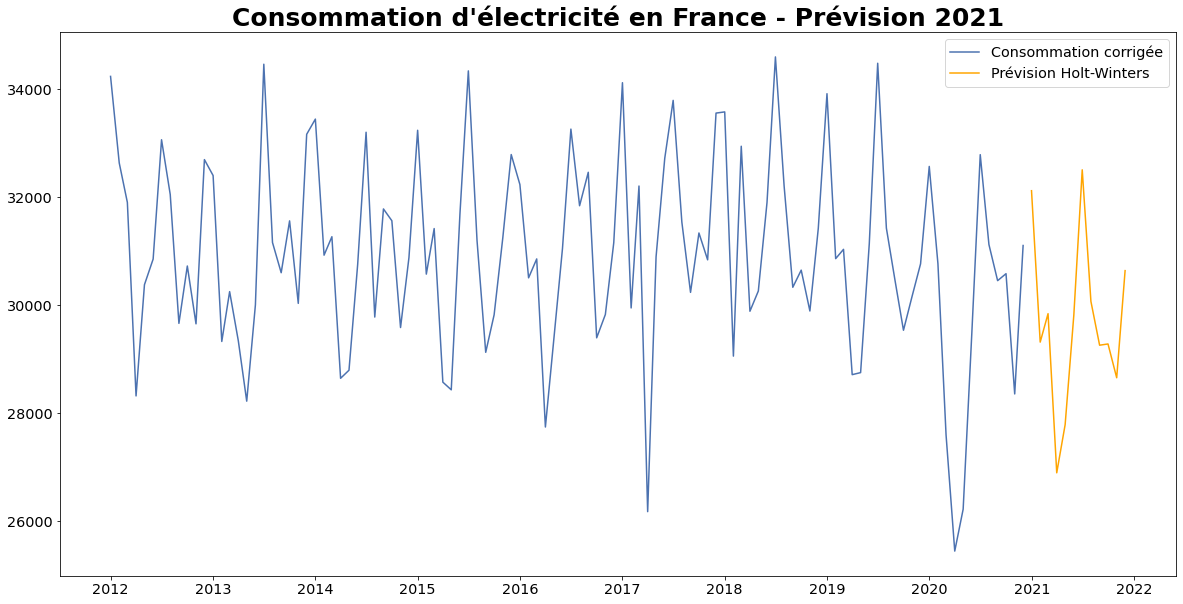

In [23]:
y = np.asarray(df["conso_corr"])
hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

#Visualisation de la prévision à 12 mois par Holt-Winters
plt.plot(df["conso_corr"], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters', color = "orange")

plt.title("Consommation d'électricité en France - Prévision 2021")

plt.savefig("p9_graphic/prevision2019_holt-winters.png")
plt.legend()
plt.show()

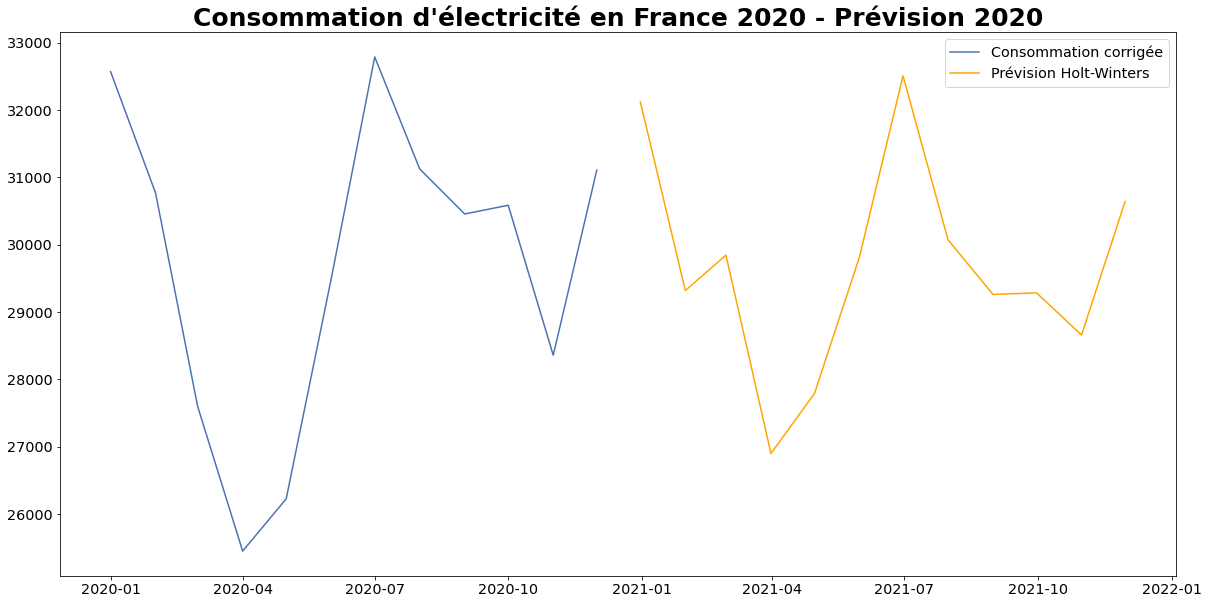

In [24]:
#Visualisation par restriction sur l'année de prévision et n-1 2020
plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(pd.date_range(df.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Prévision Holt-Winters', color = "orange")

plt.title("Consommation d'électricité en France 2020 - Prévision 2020")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182019_holt-winters.png")
plt.show()

### Analyse a posteriori sur 12 mois 

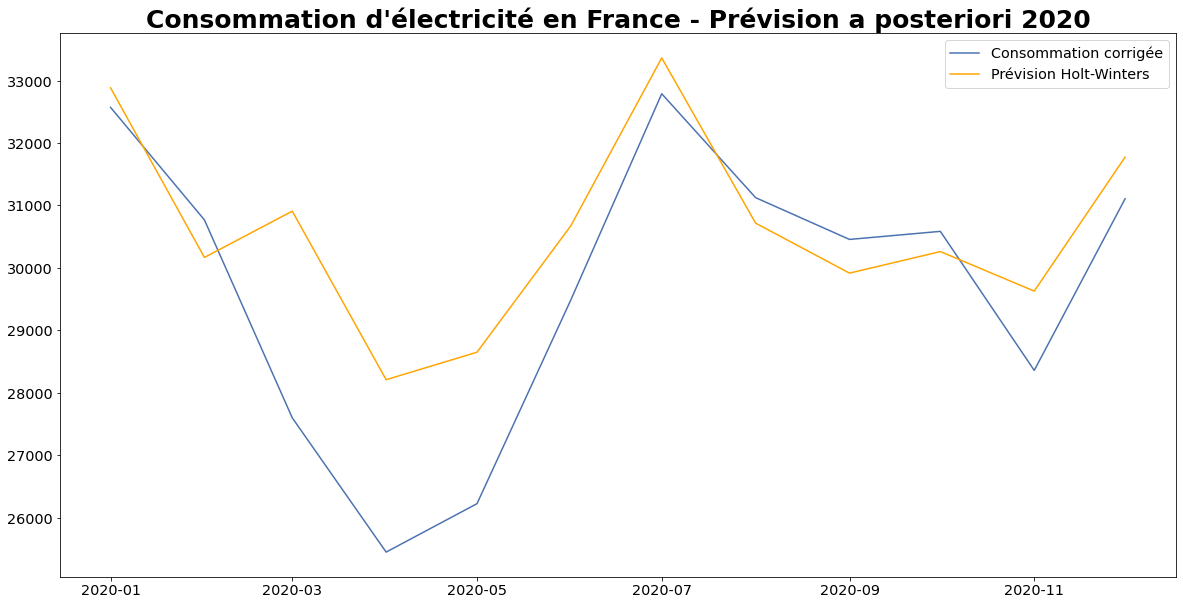

In [25]:
#Troncature des données sur les années 2019 et 2020
df_tronc = df[:'2019']
x_prevision = df['2020':]

#Visualisation par restriction sur l'année 2018
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(12)

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='orange', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France - Prévision a posteriori 2020")

plt.savefig("p9_graphic/prevision_visu20182019_holt-winters_aposteriori.png")
plt.legend()
plt.show()

In [26]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
mape

4.29

### Analyse a posteriori doublée sur 24 mois 

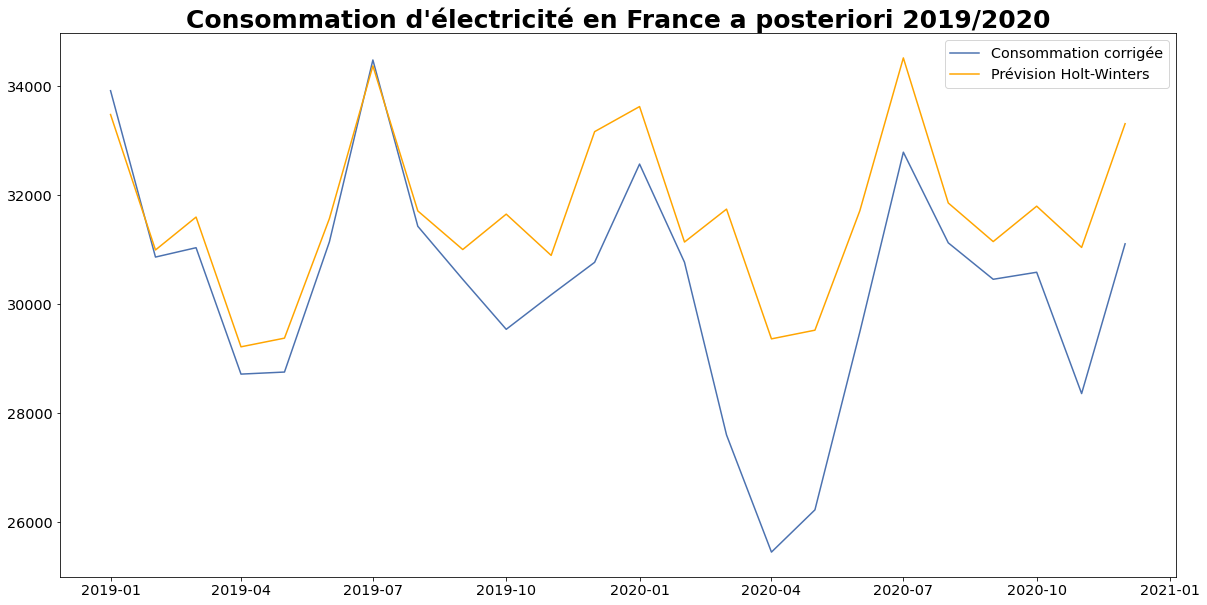

In [27]:
#Troncature des données pour une prévision a posteriori de 24 mois
df_tronc = df[:'2018']
x_prevision = df['2019':]

#Visualisation par restriction sur les années de prévision 2018 et 2019
y = df_tronc["conso_corr"]

hw = ExponentialSmoothing(y, seasonal_periods=12, trend='add', seasonal='add').fit()
hw_pred = hw.forecast(24)

plt.plot(df["conso_corr"].iloc[-24:], label='Consommation corrigée')
plt.plot(x_prevision.index, hw_pred, color='orange', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité en France a posteriori 2019/2020")

plt.savefig("p9_graphic/prevision_visu20172018_holt-winters_aposteriori.png")
plt.legend()
plt.show()


In [28]:
#Calcul du MAPE
mape = round((np.abs(1-hw_pred/x_prevision["conso_corr"])).mean()*100, 2)
print("MAPE :" + str(mape))

MAPE :4.77


Le modèle résiste plutôt bien aux impacts saisonniers sur du long terme. Malgré cela, les excédents des pics et creux ne sont pas totalement prévisibles par le modèle, les prévisions SARIMA seront-elles plus représentatives ?

### Prévision à l'aide d'un modèle ARIMA saisonnier de format : SARIMA(p,d,q)(P,D,Q)(t)

Plusieurs étapes sont nécessaires :

* stationnarisation (éventuellement),

* identification a priori de modèles potentiels,

* estimation des modèles potentiels,

* vérification des modèles potentiels,

* choix définitif d'un modèle,

* prévision à l'aide du modèle choisi,

* analyse a posteriori de la prévision.

***Stationnarité et différenciation de la série :***

Nous sommes en présence d'une série temporelle marquée par une forte saisonnalité, classique sur les températures climatiques. Il n'est pas possible de modéliser directement par un processus stationnaire, la méthode retenue sera la différenciation.

In [29]:
#Fonction affichant les autocorrélogrammes ACF et PACF
def tsplot(y, lags=None, figsize=(20, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)

        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        

        p_value = sm.tsa.stattools.adfuller(y)[1]

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

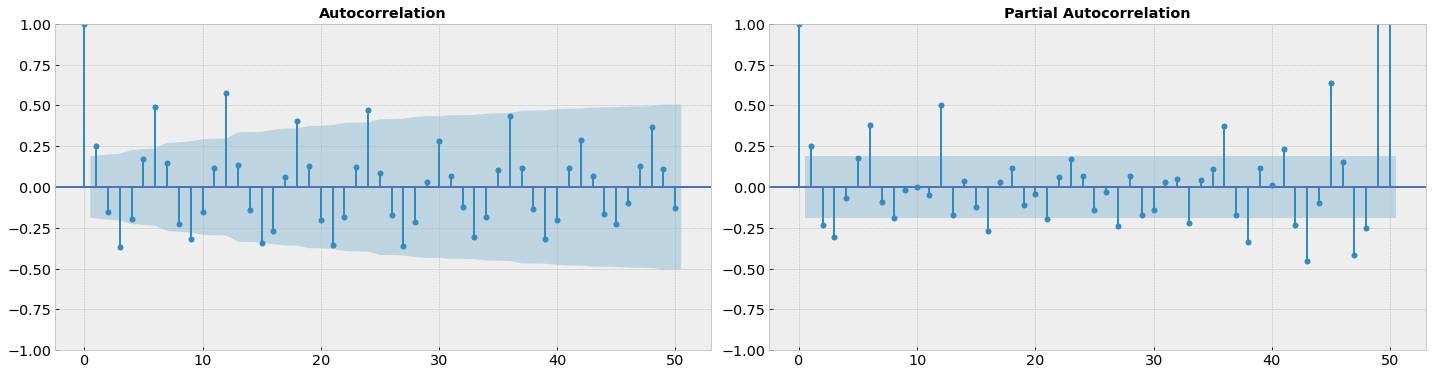

In [49]:
#Autocorrélogrammes ACF et PACF
tsplot(df['conso_corr'], lags=50)
fig.savefig('p9_graphic/Autocorrélogrammes.jpg')

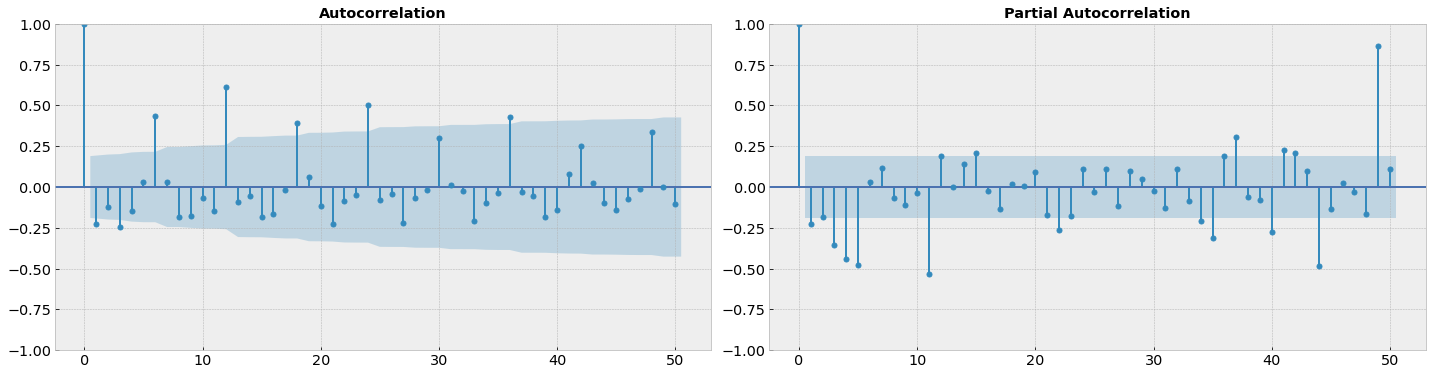

In [50]:
#Première différenciation d'ordre 1 par la méthode .shift()
df_diff1 = df['conso_corr'] - df['conso_corr'].shift(1)
tsplot(df_diff1[1:], lags=50)
fig.savefig('p9_graphic/différenciation_1_ordre.jpg')

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation d'ordre 12.

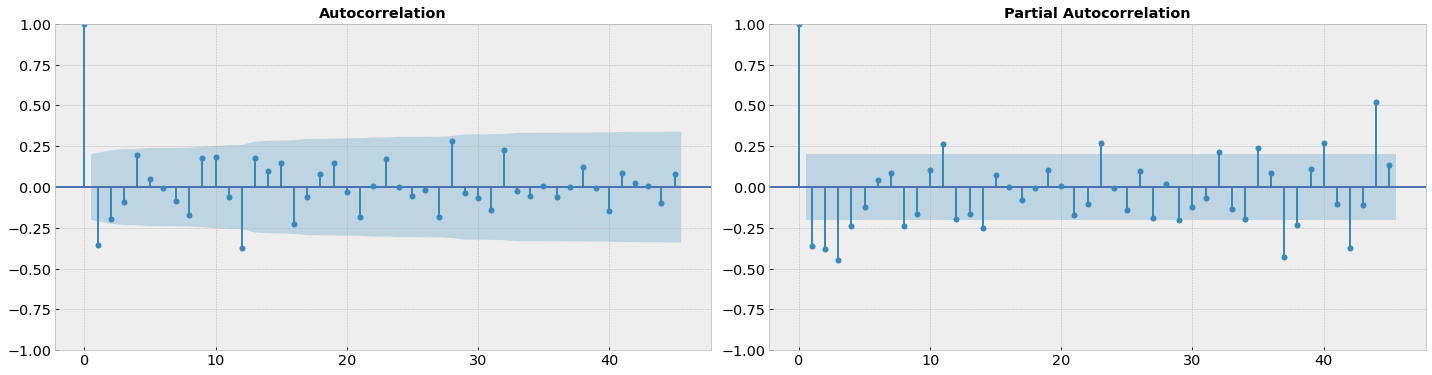

In [51]:
#Seconde différenciation d'ordre 12 
df_diff1_12 = df_diff1 - df_diff1.shift(12)
tsplot(df_diff1_12[13:], lags=45)
fig.savefig('p9_graphic/différenciation_12_ordre.jpg')

In [33]:
#Instanciation et entrainement du modèle SARIMA via statsmodels

model = SARIMAX(np.asarray(df['conso_corr']), order=(1,0,1), seasonal_order=(1,1,1,12))
results = model.fit()
print(results.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results.resid, lags=elt)[1:].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -830.752
Date:                            Wed, 16 Feb 2022   AIC                           1671.505
Time:                                    17:39:39   BIC                           1684.327
Sample:                                         0   HQIC                          1676.688
                                            - 108                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3769      0.651     -0.579      0.562      -1.652       0.899
ma.L1          0.4471      0.650   

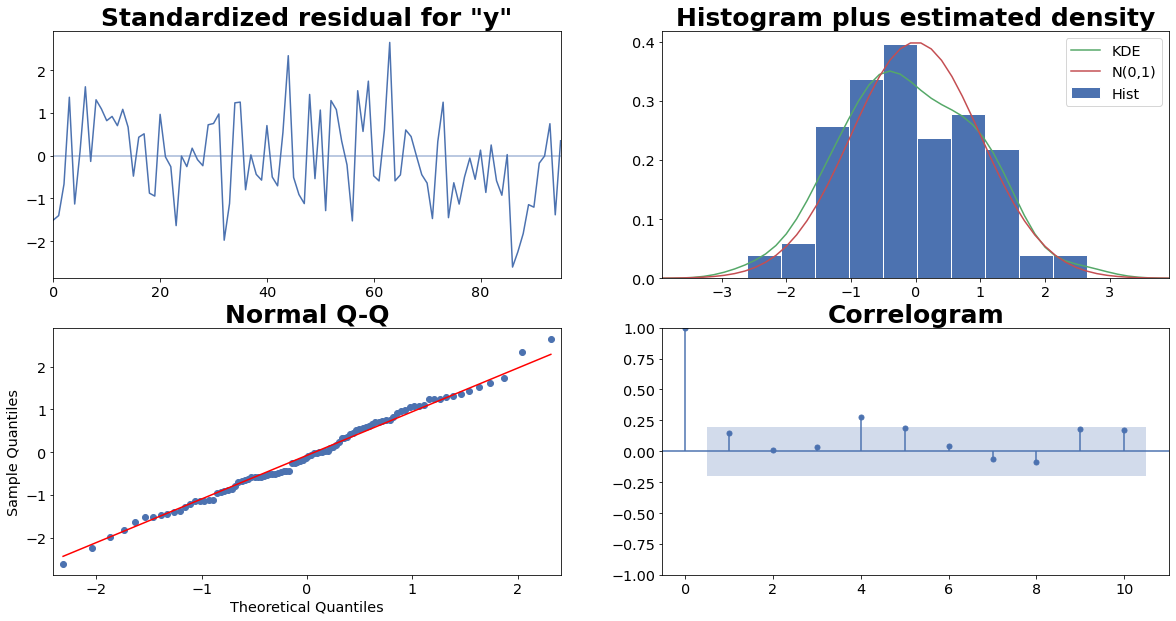

In [48]:
#La fonction .plot_diagnostics() permet d'établir un diagnostic rapide du modèle SARIMA identifié  
fig = results.plot_diagnostics()
fig.savefig('p9_graphic/plot_diagnostics.jpg')

In [35]:
#Test de Shapiro-Wilk
from scipy.stats import shapiro
shapiro(results.resid)

ShapiroResult(statistic=0.5013996362686157, pvalue=1.800020451787253e-17)

In [36]:
#Test de Jarque-Bera
results.test_normality("jarquebera")[0][1]

0.7874927208957351

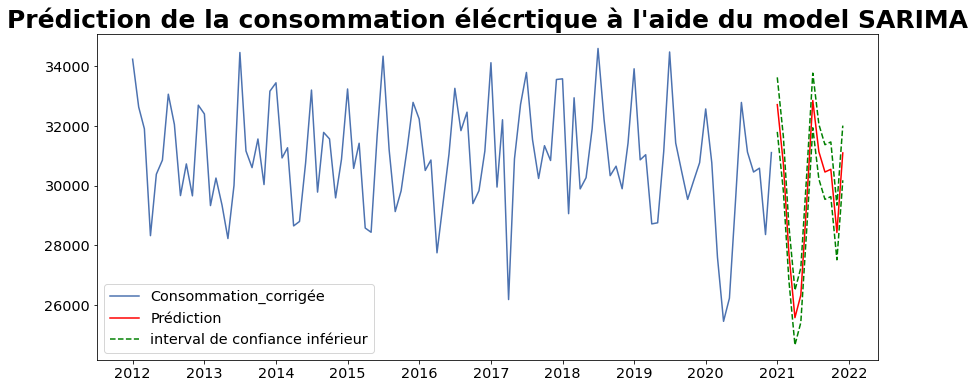

In [47]:
#Visualisation de la prévision à 12 mois par la méthode SARIMA
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean
pred_l = [elt[0] for elt in pred_model.conf_int(alpha=0.5)]
pred_u = [elt[1] for elt in pred_model.conf_int(alpha=0.5)]

plt.figure(figsize=(14,6))
plt.plot(df['conso_corr'], label='Consommation_corrigée')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prédiction')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--',label="interval de confiance inférieur")
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.title("Prédiction de la consommation élécrtique à l'aide du model SARIMA")
plt.legend()
plt.savefig('p9_graphic/sarima_prevision_int95.jpg')
plt.show()

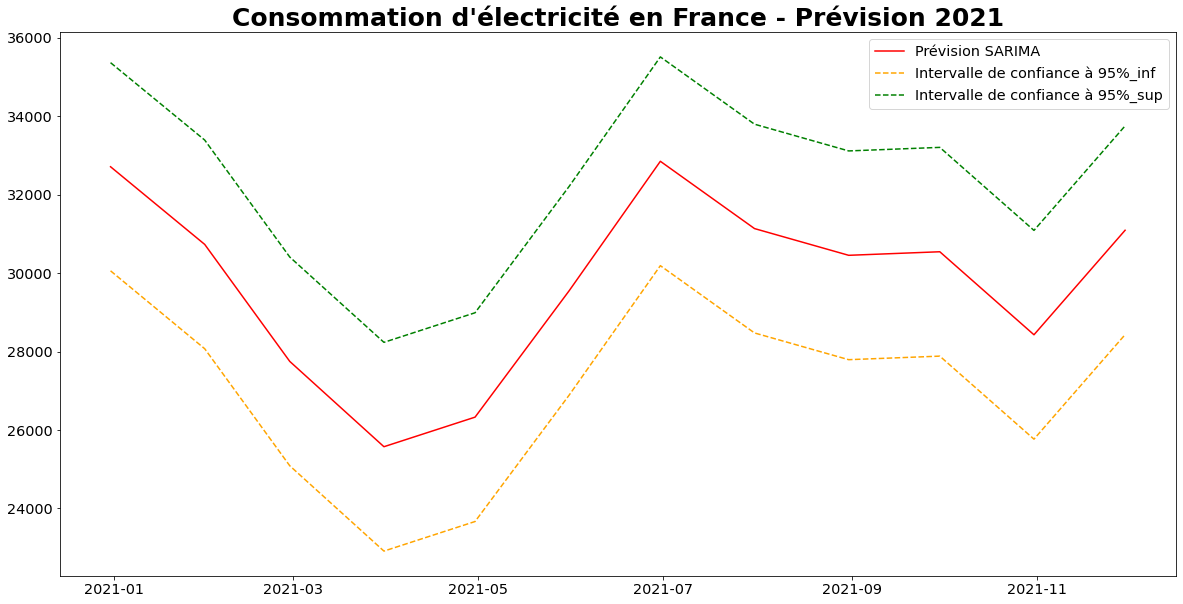

In [39]:
#Visualisation des intervalles de confiance sur la prévision à 12 mois
pred_model = results.get_forecast(12)
pred = pred_model.predicted_mean

pred_l = [(elt[0]) for elt in pred_model.conf_int(alpha=0.05)]
pred_u = [(elt[1]) for elt in pred_model.conf_int(alpha=0.05)]

plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), pred, color='r', label='Prévision SARIMA')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_l, color='orange', linestyle='--', label='Intervalle de confiance à 95%_inf')
plt.plot(pd.date_range(df.index[len(df)-1], periods=12, freq='M'), 
         pred_u, color='g', linestyle='--', label='Intervalle de confiance à 95%_sup')

plt.title("Consommation d'électricité en France - Prévision 2021")
plt.legend()

plt.savefig('p9_graphic/sarima_prevision2019_int95.jpg')
plt.show() 

### Analyse a posteriori SARIMA

In [40]:
#Troncature des données sur l'année 2020
df_tronc = df[:'2019'] 
x_prevision = df['2020':]  

model_tronc = SARIMAX(np.asarray(df_tronc['conso_corr']), order=(1,0,1), seasonal_order=(1,1,1,12))
results_tronc = model_tronc.fit()
print(results_tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results_tronc.resid, lags=elt)[1:].mean()))

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                   96
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -720.426
Date:                            Wed, 16 Feb 2022   AIC                           1450.852
Time:                                    17:46:09   BIC                           1463.006
Sample:                                         0   HQIC                          1455.738
                                             - 96                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6080      0.339      1.795      0.073      -0.056       1.272
ma.L1         -0.6591      0.296   

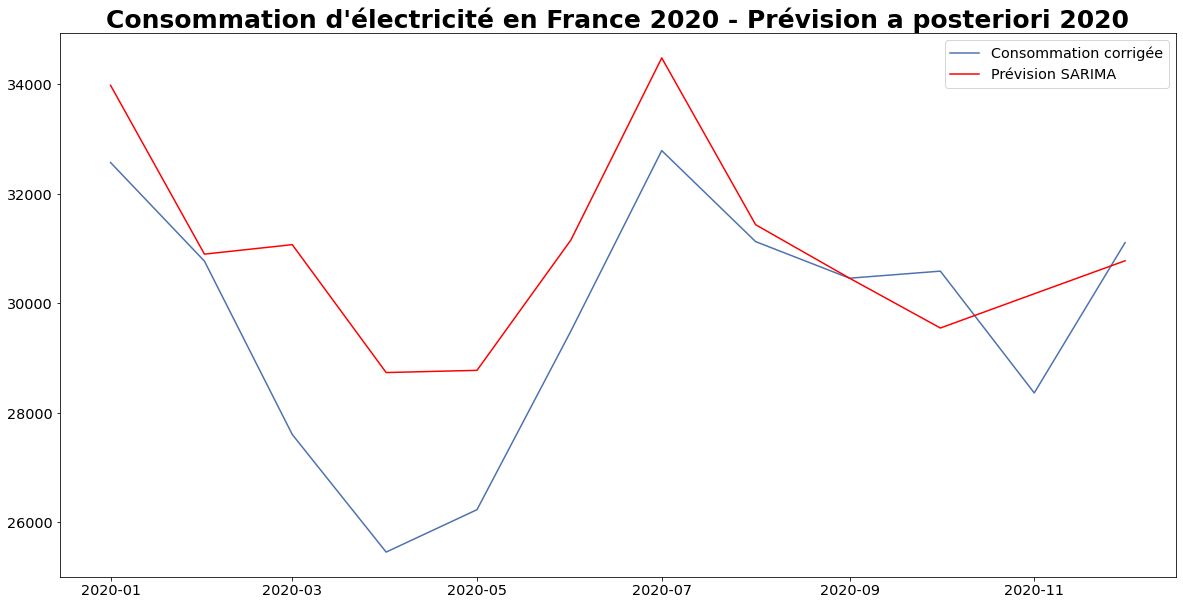

In [41]:
#Visualisation par restriction sur l'année 2020
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')


plt.title("Consommation d'électricité en France 2020 - Prévision a posteriori 2020")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()

In [42]:
mape = round((np.abs(1-pred_tronc/x_prevision["conso_corr"])).mean()*100, 2)
mape

5.21

In [43]:
#Root mean square error
rmse = np.sqrt(((x_prevision['conso_corr']-pred_tronc)**2).mean())
rmse

1859.4453766797483

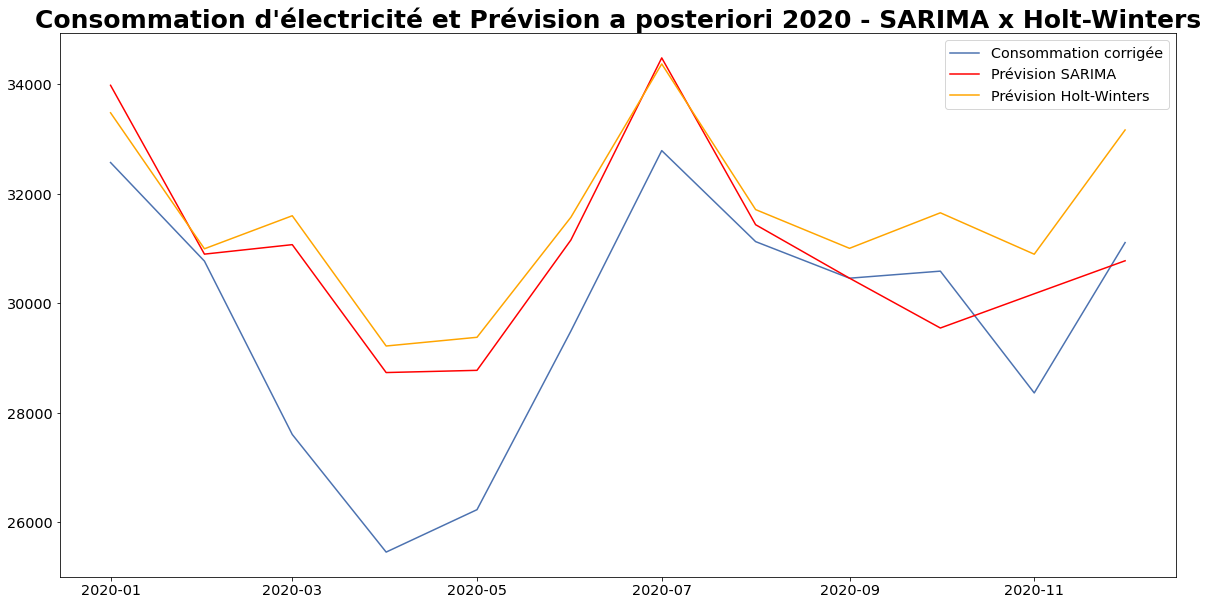

In [53]:
#Troncature des données sur l'année 2020
df_tronc = df[:'2019'] 
x_prevision = df['2020':]  
hw_pred = hw.forecast(12)
#Visualisation par restriction sur l'année 2020
pred_model_tronc = results_tronc.get_forecast(12)
pred_tronc = pred_model_tronc.predicted_mean

plt.plot(df["conso_corr"].iloc[-12:], label='Consommation corrigée')
plt.plot(x_prevision.index, pred_tronc, color='r', label='Prévision SARIMA')
plt.plot(x_prevision.index, hw_pred, color='orange', label='Prévision Holt-Winters')

plt.title("Consommation d'électricité et Prévision a posteriori 2020 - SARIMA x Holt-Winters")
        
plt.legend()
plt.savefig("p9_graphic/prevision_visu20182018_sarima_aposteriori.png")
plt.show()